Q1

Forecast Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as tsa_plots
from matplotlib.patches import Rectangle
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_profiling as pp
import itertools
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
savedata=pd.read_excel('Airlines+Data.xlsx')
savedata 

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [3]:
data = savedata.copy()

In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [5]:
#data visualization
viz=pd.read_excel('Airlines+Data.xlsx',
                  header=0,index_col=0,parse_dates=True,squeeze=True)
viz

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2002-08-01    405
2002-09-01    355
2002-10-01    306
2002-11-01    271
2002-12-01    306
Name: Passengers, Length: 96, dtype: int64

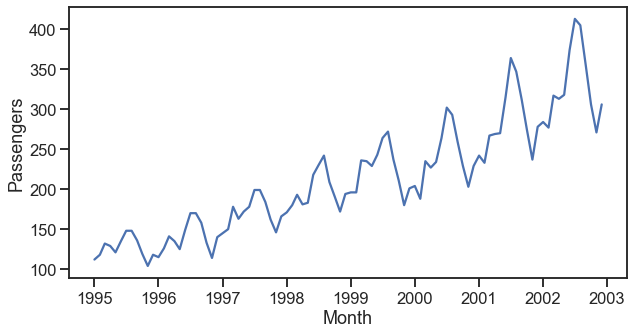

In [6]:
#Line plot
sns.set(rc={'figure.figsize':(10,5)})
sns.set(style="ticks", context="talk")
sns.lineplot(data=viz)
plt.show()

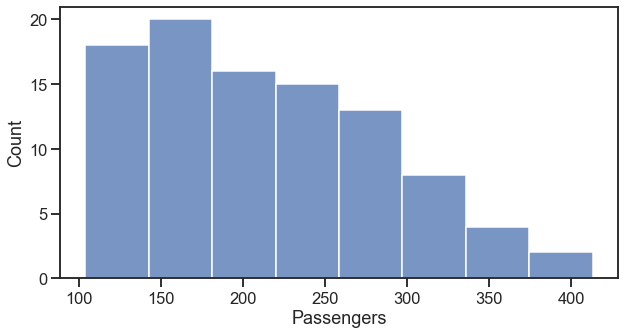

In [7]:
sns.histplot(data=viz)
plt.show() #Passenger count with months

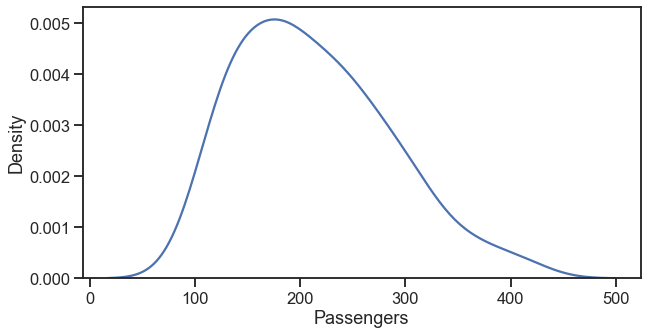

In [8]:
sns.kdeplot(data=viz)
plt.show() #Density Plot

Text(0.5, 1.0, 'Heatmap of Passenger Count')

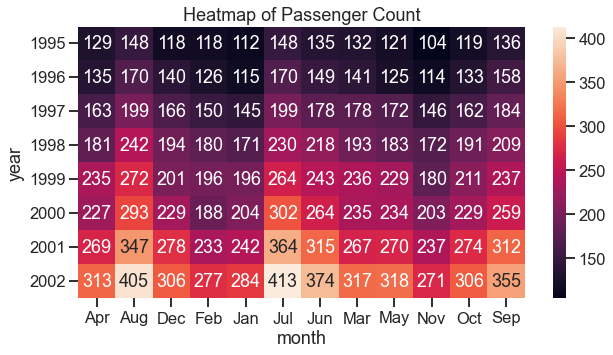

In [9]:
data["month"] = data.Month.dt.strftime("%b") # month extraction
data["year"] = data.Month.dt.strftime("%Y") # year extraction
heatmap_y_month = pd.pivot_table(data=data,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.title('Heatmap of Passenger Count')

In [10]:
group=viz.groupby(pd.Grouper(freq='A'))
group.sum()

Month
1995-12-31    1520
1996-12-31    1676
1997-12-31    2042
1998-12-31    2364
1999-12-31    2700
2000-12-31    2867
2001-12-31    3408
2002-12-31    3939
Freq: A-DEC, Name: Passengers, dtype: int64

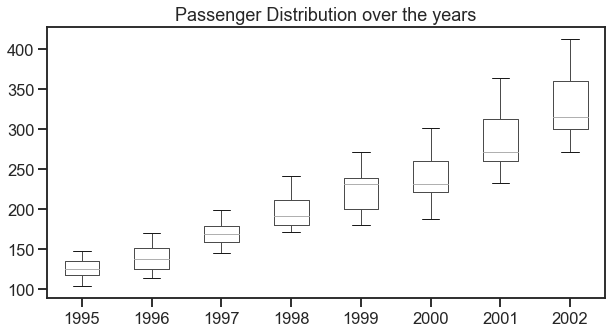

In [11]:
years=pd.DataFrame()
for i,j in group:
    years[i.year]=j.values
years.boxplot(grid=False)
plt.title('Passenger Distribution over the years')
plt.show()

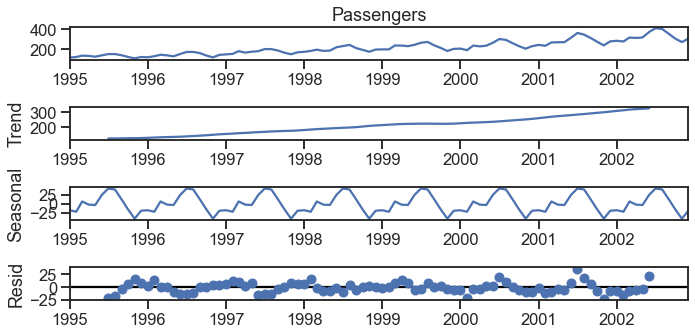

In [12]:
#seasonal decompose plot
decompose_ts = seasonal_decompose(viz,period=12)
decompose_ts.plot()
plt.show()

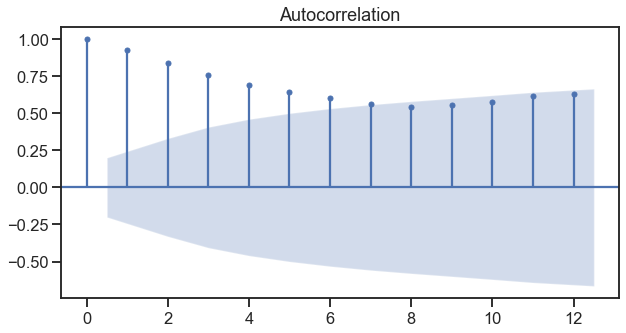

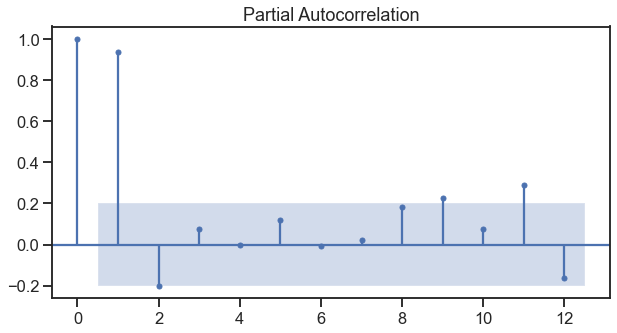

In [13]:
#ACF
tsa_plots.plot_acf(viz,lags=12) 
#Autocorrelation Factor >> uptill 6 we have good corr() above +-2 SE [Standard Error]
#PACF
tsa_plots.plot_pacf(viz,lags=12) 
#Partial Autocorrelation Factor >> only 9 and 11 show some good corr() +-2 SE [Standard Error]
plt.show()

In [14]:
#preprocessing data
#transformations
# adding t values >> new variable 1
data['t']= np.arange(1,data.shape[0]+1) 
# adding t_sqr values >> new variable 2
data['t_sqr'] = data['t']**2
# adding log_ values >> new variable 3
data['log_psgr'] = np.log(data['Passengers'])

In [15]:
#dummies for months
month_dummies = pd.DataFrame(pd.get_dummies(data['month']))
data = pd.concat([data,month_dummies],axis = 1)
data

,Month,Passengers,month,year,t,t_sqr,log_psgr,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,Aug,2002,92,8464,6.003887,0,1,0,0,0,0,0,0,0,0,0,0
92,2002-09-01,355,Sep,2002,93,8649,5.872118,0,0,0,0,0,0,0,0,0,0,0,1
93,2002-10-01,306,Oct,2002,94,8836,5.723585,0,0,0,0,0,0,0,0,0,0,1,0
94,2002-11-01,271,Nov,2002,95,9025,5.602119,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
#Partition and matrix series
#partition
train = data.iloc[:84]
test = data.iloc[84:]

In [17]:
#performance metrics 
pfm_model_bsd = dict() # model driven
pfm_data_bsd = dict() #  Data driven

In [18]:
#Linear Model
linear_model = smf.ols('Passengers~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = mean_squared_error(test.Passengers, pred_linear, squared=False) #RMSE Calculation
pfm_model_bsd.update( {'Linear Model' : rmse_linear} )
rmse_linear

53.19923653480271

In [19]:
#Quadratic 
Quad = smf.ols('Passengers~t+t_sqr',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_sqr"]]))
rmse_Quad = mean_squared_error(test.Passengers,pred_Quad, squared=False)
pfm_model_bsd.update( {'Quadratic Model' : rmse_Quad} )
rmse_Quad

48.05188897933093

In [20]:
#Exponential
Exp = smf.ols('log_psgr~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = mean_squared_error(test.Passengers, pred_Exp, squared=False)
pfm_model_bsd.update( {'Exponential Model' : rmse_Exp} )
rmse_Exp

325.71506135515364

In [21]:
#Additive seasonality 
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = mean_squared_error(test.Passengers,pred_add_sea, squared=False)
pfm_model_bsd.update( {'Additive seasonality' : rmse_add_sea} )
rmse_add_sea

132.81978481421817

In [22]:
#Multiplicative Seasonality
Mul_sea = smf.ols('log_psgr~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = mean_squared_error(test.Passengers,pred_Mult_sea, squared=False)
pfm_model_bsd.update( {'Multiplicative Seasonality' : rmse_Mult_sea} )
rmse_Mult_sea

326.2267987143024

In [23]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Passengers~t+t_sqr+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqr']]))
rmse_add_sea_quad = mean_squared_error(test.Passengers,pred_add_sea_quad, squared=False)
pfm_model_bsd.update( {'Additive Seasonality Quadratic' : rmse_add_sea_quad} )
rmse_add_sea_quad

26.36081761209355

In [24]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('log_psgr~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = mean_squared_error(test.Passengers,pred_Mult_add_sea, squared=False)
pfm_model_bsd.update( {'Multiplicative Additive Seasonality ' : rmse_Mult_add_sea} )
rmse_Mult_add_sea 

325.6952488040335

In [25]:
result_model_bsd = pd.DataFrame(pfm_model_bsd.items(),columns=['MODEL', 'RMSE'])
result_model_bsd.sort_values(by=['RMSE'])
#Additive Seasonality Quadratic has the lowest RMSE value

,MODEL,RMSE
5,Additive Seasonality Quadratic,26.360818
1,Quadratic Model,48.051889
0,Linear Model,53.199237
3,Additive seasonality,132.819785
6,Multiplicative Additive Seasonality,325.695249
2,Exponential Model,325.715061
4,Multiplicative Seasonality,326.226799


In [26]:
#Model Evaluation using Additive Seasonality Quadratic
data2 = data.copy()
data2

,Month,Passengers,month,year,t,t_sqr,log_psgr,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,Aug,2002,92,8464,6.003887,0,1,0,0,0,0,0,0,0,0,0,0
92,2002-09-01,355,Sep,2002,93,8649,5.872118,0,0,0,0,0,0,0,0,0,0,0,1
93,2002-10-01,306,Oct,2002,94,8836,5.723585,0,0,0,0,0,0,0,0,0,0,1,0
94,2002-11-01,271,Nov,2002,95,9025,5.602119,0,0,0,0,0,0,0,0,0,1,0,0


In [27]:
data2.columns.values
data2.drop([ 't_sqr','Month','log_psgr',
       'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], axis=1, inplace=True)
data2 = data2[['t', 'year', 'month', 'Passengers']] 
data1 = data2.copy()
data3 = data2.copy()
data_final = data2.copy()
data2

,t,year,month,Passengers
0,1,1995,Jan,112
1,2,1995,Feb,118
2,3,1995,Mar,132
3,4,1995,Apr,129
4,5,1995,May,121
...,...,...,...,...
91,92,2002,Aug,405
92,93,2002,Sep,355
93,94,2002,Oct,306
94,95,2002,Nov,271


In [28]:
data2["Predicted"] = pd.Series(add_sea_Quad.predict(data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqr']]))
data2.head()

C:\Users\amanu\AppData\Local\Temp/ipykernel_13008/2158645069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["Predicted"] = pd.Series(add_sea_Quad.predict(data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqr']]))


,t,year,month,Passengers,Predicted
0,1,1995,Jan,112,100.121972
1,2,1995,Feb,118,100.427467
2,3,1995,Mar,132,127.161533
3,4,1995,Apr,129,120.467028
4,5,1995,May,121,119.201095


In [29]:
# add a date column in the dataset
data2['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')
data2.head()

C:\Users\amanu\AppData\Local\Temp/ipykernel_13008/334213742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')


,t,year,month,Passengers,Predicted,Date
0,1,1995,Jan,112,100.121972,1995-01-01
1,2,1995,Feb,118,100.427467,1995-02-01
2,3,1995,Mar,132,127.161533,1995-03-01
3,4,1995,Apr,129,120.467028,1995-04-01
4,5,1995,May,121,119.201095,1995-05-01


<AxesSubplot:xlabel='Date', ylabel='Value'>

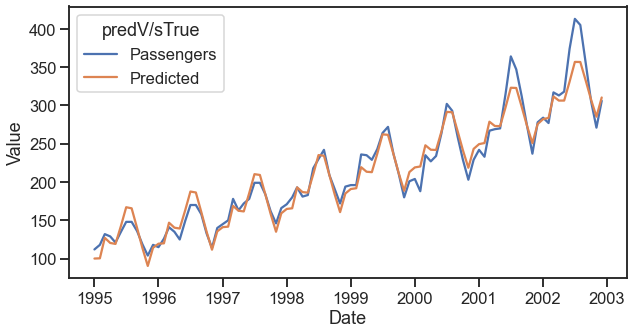

In [30]:
# line plot - View for the entire dataset Additive seasonality Quadratic
viz2 = data2.loc[:,["Date","Passengers","Predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz2, x=viz2.Date, y=viz2.Value,hue="predV/sTrue")
#There is large variance

C:\Users\amanu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Date', ylabel='Value'>

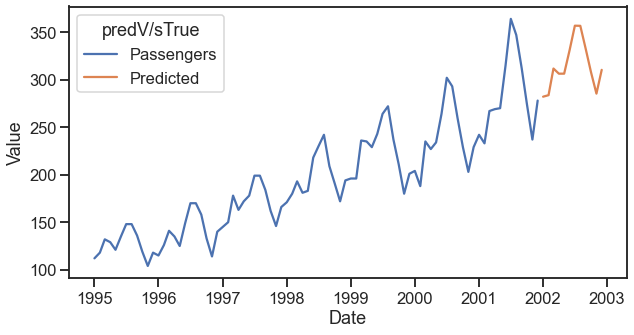

In [31]:
#Line plot - Train V Test Plot
data2.Predicted.iloc[:84] = np.nan
data2.Passengers.iloc[84:] = np.nan

viz3 = data2.loc[:,["Date","Passengers","Predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz3, x=viz3.Date, y=viz3.Value,hue="predV/sTrue")
#There is large variance

In [32]:
#using pycaret

In [33]:
#Partition Series
train1 = data1.iloc[:84]
test1 = data1.iloc[84:]

In [34]:
#pycaret regression module
from pycaret.regression import *
# initialize setup
s = setup(data = train1, test_data = test1, target = 'Passengers', 
          fold_strategy = 'timeseries', numeric_features = ['year', 't'], 
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Passengers
2,Original Data,"(84, 4)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(84, 14)"


In [35]:
best = compare_models(sort = 'RMSE')
#lowest RMSE for RidgeR

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,13.6296,272.9917,16.4964,0.6555,0.0776,0.0652,0.4933
br,Bayesian Ridge,14.5454,324.4770,17.6463,0.5466,0.0888,0.0729,0.0067
lr,Linear Regression,14.5802,329.8146,17.7143,0.5340,0.0898,0.0736,0.6067
huber,Huber Regressor,16.1185,379.5074,19.2331,0.4958,0.0962,0.0801,0.0100
omp,Orthogonal Matching Pursuit,24.1095,872.4655,28.4732,0.1070,0.1280,0.1108,0.0067
en,Elastic Net,23.4992,884.3336,28.8580,0.0858,0.1289,0.1056,0.4967
lasso,Lasso Regression,24.4109,957.0823,30.4079,-0.0238,0.1366,0.1092,0.4867
dt,Decision Tree Regressor,27.4762,1288.0794,34.1757,-0.2275,0.1568,0.1233,0.0067
gbr,Gradient Boosting Regressor,30.2016,1543.3668,35.1711,-0.2883,0.1572,0.1289,0.0100
rf,Random Forest Regressor,32.4908,1842.0834,39.3934,-0.5801,0.1737,0.1348,0.0333


In [36]:
# generate predictions on the original dataset
predictions = predict_model(best, data=data1)
predictions.head()

,t,year,month,Passengers,Label
0,1,1995,Jan,112,110.109917
1,2,1995,Feb,118,111.732735
2,3,1995,Mar,132,127.183121
3,4,1995,Apr,129,123.364624
4,5,1995,May,121,122.470360


In [37]:
# adding a date column in the dataset
predictions['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')
predictions.head()

,t,year,month,Passengers,Label,Date
0,1,1995,Jan,112,110.109917,1995-01-01
1,2,1995,Feb,118,111.732735,1995-02-01
2,3,1995,Mar,132,127.183121,1995-03-01
3,4,1995,Apr,129,123.364624,1995-04-01
4,5,1995,May,121,122.470360,1995-05-01


<AxesSubplot:xlabel='Date', ylabel='Value'>

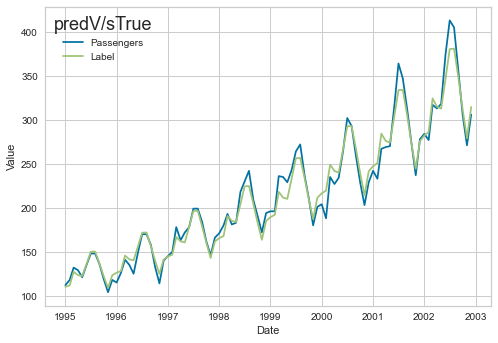

In [38]:
# line plot - entire dataset

viz1 = predictions.loc[:,["Date","Passengers","Label"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz1, x=viz1.Date, y=viz1.Value,hue="predV/sTrue")

<AxesSubplot:xlabel='Date', ylabel='Value'>

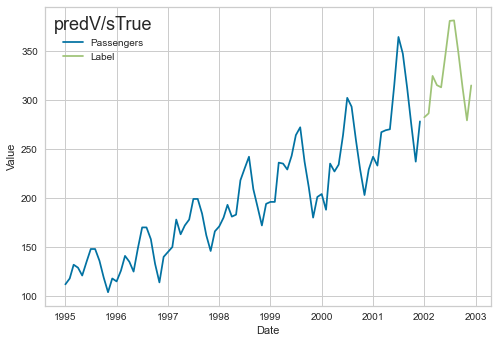

In [39]:
# line plot Train vs test

predictions.Label.iloc[:84] = np.nan
predictions.Passengers.iloc[84:] = np.nan

viz4 = predictions.loc[:,["Date","Passengers","Label"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz4, x=viz4.Date, y=viz4.Value,hue="predV/sTrue")

In [40]:
#data driven forecasting
#Making seperate dataset
data_ma = savedata.copy()
data_ma = data_ma.set_index('Month')

#Simple Moving Average SMA
data_ma['3-month-SMA'] = data_ma['Passengers'].rolling(window=3).mean()
data_ma['6-month-SMA'] = data_ma['Passengers'].rolling(window=6).mean()
data_ma['12-month-SMA'] = data_ma['Passengers'].rolling(window=12).mean()

data_ma.head()

,Passengers,3-month-SMA,6-month-SMA,12-month-SMA
Month,,,,
1995-01-01,112,NaN,NaN,NaN
1995-02-01,118,NaN,NaN,NaN
1995-03-01,132,120.666667,NaN,NaN
1995-04-01,129,126.333333,NaN,NaN
1995-05-01,121,127.333333,NaN,NaN


<AxesSubplot:xlabel='Month'>

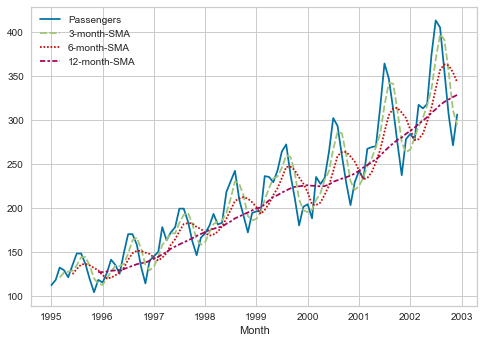

In [41]:
#SMA plot
sns.lineplot(data=data_ma)

In [42]:
data_ma['3-month-SMA']=data_ma['3-month-SMA'].fillna(0)
rmse_SMA_3Months = mean_squared_error(data_ma.Passengers,data_ma['3-month-SMA'], squared=False)
pfm_data_bsd.update({'SMA-3Months':rmse_SMA_3Months}) 
rmse_SMA_3Months
#RMSE is lowest for 3 months

25.172299774274222

<AxesSubplot:xlabel='Month'>

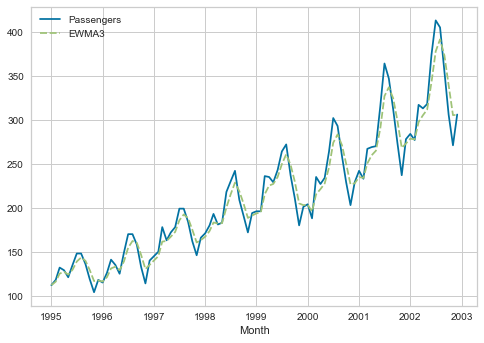

In [43]:
#Average EWMA
data_ma['EWMA3'] = data_ma['Passengers'].ewm(span=3,adjust=True).mean() #3month Span

#Line Plot EWMA
sns.lineplot(data=data_ma[["Passengers","EWMA3"]]) #SMA Plot

In [44]:
#lowest EWMA for 3 months
data_ma['EWMA3'] =data_ma['EWMA3'] .fillna(0)
rmse_EWMA3 = mean_squared_error(data_ma.Passengers,data_ma['EWMA3'] , squared=False)
pfm_data_bsd.update({'EWMA 3Months':rmse_EWMA3}) 
rmse_EWMA3 

13.973908389658527

In [45]:
#smoothing technique
#Simple Exponential Method
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
rmse_SES = mean_squared_error(test.Passengers,pred_ses, squared=False)
pfm_data_bsd.update({'SES':rmse_SES}) 
rmse_SES

64.84476396990497

In [46]:
# Holt method 
hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
rmse_Holt = mean_squared_error(test.Passengers,pred_hw, squared=False)
pfm_data_bsd.update({'Holt':rmse_Holt}) 
rmse_Holt

95.76674452675282

In [47]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_mul = mean_squared_error(test.Passengers,pred_hwe_mul_add, squared=False)
pfm_data_bsd.update({'HWE Mul. Seas & Add. Trend':rmse_hwe_mul}) 
rmse_hwe_mul

12.920700425462794

In [48]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_add = mean_squared_error(test.Passengers,pred_hwe_add_add, squared=False)
pfm_data_bsd.update({'HWE Add. Seas & Add. Trend':rmse_hwe_add}) 
rmse_hwe_add

28.821803918224518

In [49]:
pfm_data_bsd

{'SMA-3Months': 25.172299774274222,
 'EWMA 3Months': 13.973908389658527,
 'SES': 64.84476396990497,
 'Holt': 95.76674452675282,
 'HWE Mul. Seas & Add. Trend': 12.920700425462794,
 'HWE Add. Seas & Add. Trend': 28.821803918224518}

In [50]:
result_data_bsd = pd.DataFrame(pfm_data_bsd.items(),columns=['MODEL', 'RMSE'])
result_data_bsd.sort_values(by=['RMSE'])
#Lowest RMSE value for Holt winter Exponential Multiplicative Seasonality and Additive Trend

,MODEL,RMSE
4,HWE Mul. Seas & Add. Trend,12.920700
1,EWMA 3Months,13.973908
0,SMA-3Months,25.172300
5,HWE Add. Seas & Add. Trend,28.821804
2,SES,64.844764
3,Holt,95.766745


In [51]:
#Model Evaluation Holt winter exponential Multiplicative Seasonality and Additive Trend
hwe_mul_model = hwe_model_mul_add.predict(start = data.index[0],end = data.index[-1])
data3['predicted'] = hwe_mul_model
data3.head()

,t,year,month,Passengers,predicted
0,1,1995,Jan,112,113.112975
1,2,1995,Feb,118,112.379635
2,3,1995,Mar,132,136.033355
3,4,1995,Apr,129,130.315239
4,5,1995,May,121,130.048758


In [52]:
# add a date column in the dataset
data3['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')
data3.head()

,t,year,month,Passengers,predicted,Date
0,1,1995,Jan,112,113.112975,1995-01-01
1,2,1995,Feb,118,112.379635,1995-02-01
2,3,1995,Mar,132,136.033355,1995-03-01
3,4,1995,Apr,129,130.315239,1995-04-01
4,5,1995,May,121,130.048758,1995-05-01


<AxesSubplot:xlabel='Date', ylabel='Value'>

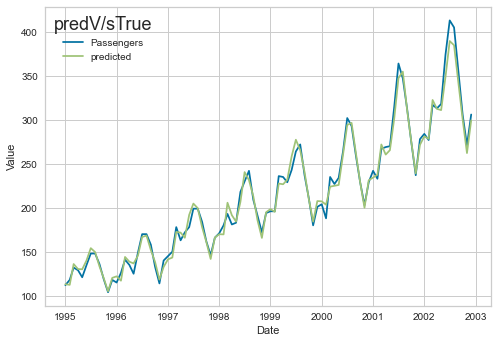

In [53]:
# line plot - View for the entire dataset _ Additive Seasonality Quadratic
viz5 = data3.loc[:,["Date","Passengers","predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz5, x=viz5.Date, y=viz5.Value,hue="predV/sTrue")
#lowest variance

<AxesSubplot:xlabel='Date', ylabel='Value'>

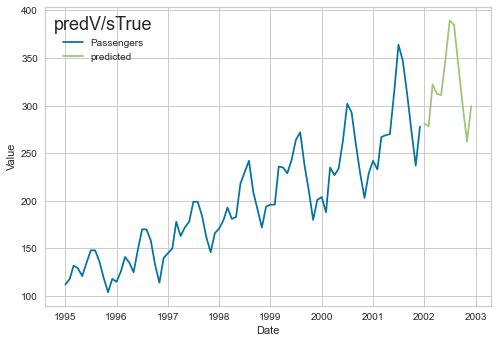

In [54]:
#Line plot Train V Test Plot
data3.predicted.iloc[:84] = np.nan
data3.Passengers.iloc[84:] = np.nan

viz6 = data3.loc[:,["Date","Passengers","predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz6, x=viz6.Date, y=viz6.Value,hue="predV/sTrue")
#Best internal forecast

In [55]:
#Auto Regression Model
#low chances of being the data stationary, has both trend and seasonality.
#perform AD-Fuller stationarity test to find stationarity.
#ACF and PACF plots

#AD-Fuller stationarity test
from statsmodels.tsa.stattools import adfuller

In [56]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [57]:
data4=savedata.copy()
data4=data4.set_index('Month')
data4.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [58]:
adf_test(data4)
#non stationary data

Fail to reject the null hypothesis
Data is non-stationary


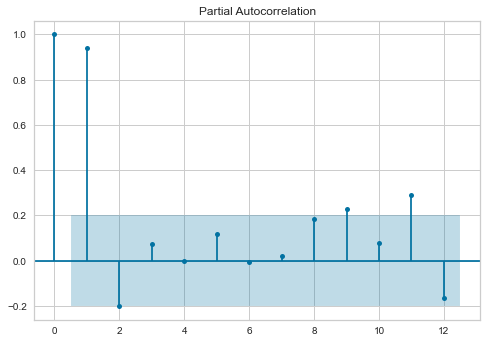

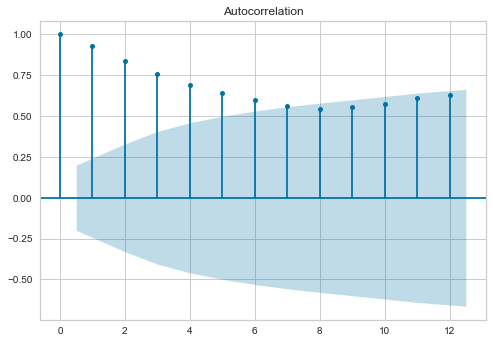

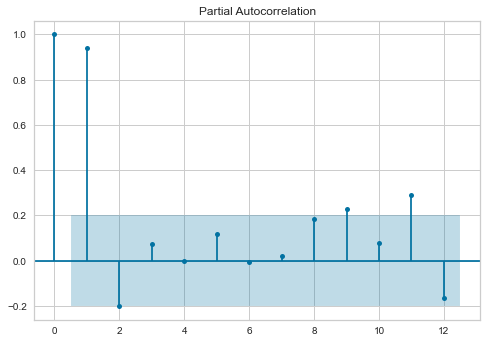

In [59]:
#ACF and PACF Plot
tsa_plots.plot_acf(viz,lags=12) 
#Autocorrelation Factor >> uptill 6 we have good corr() above +-2 SE [Standard Error]
tsa_plots.plot_pacf(viz,lags=12) 
#Partial Autocorrelation Factor >> only 9 and 11 show some good corr() +-2 SE [Standard Error]

In [60]:
# for determining ARIMA orders
from pmdarima import auto_arima

In [61]:
stepwise_fit = auto_arima(data4.Passengers, start_p=0, start_q=0,
                          max_p=12, max_q=12, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)          

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=871.345, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=867.283, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=863.757, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=870.076, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=862.193, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=861.773, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=860.702, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=862.251, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=855.919, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=860.821, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=856.719, Time=0.05 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -421.170
Date:                Wed, 05 Jan 2022   AIC                            854.341
Time:                        13:05:42   BIC                            869.664
Sample:                             0   HQIC                           860.533
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.142      1.071      0.284      -0.127       0.432
ar.L2          0.4062      0.144      2.815      0.005       0.123       0.689
ar.L3         -0.3167      0.121     -2.619      0.009      -0.554      -0.080
ma.L1          0.1470      0.121      1.215      0.224      -0.090       0.384
ma.L2         -0.7809      0.116     -6.734      0.000      -1.008      -0.554
sigma2       409.9286     75.390      5.437      0.000     262.167     557.690
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.41   Prob(JB):                         0.14
Heteroskedasticity (H):               3.63   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
#Fitting arima model
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(train['Passengers'],order=(3,1,2))
results = model_arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                   83
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -358.852
Method:                       css-mle   S.D. of innovations             17.563
Date:                Wed, 05 Jan 2022   AIC                            731.704
Time:                        13:05:42   BIC                            748.636
Sample:                             1   HQIC                           738.506
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2520      2.130      1.057      0.290      -1.923       6.427
ar.L1.D.Passengers     0.9960      0.119      8.372      0.000       0.763       1.229
ar.L2.D.Passengers    -0.9938      0.123     -8.109      0.000      -1.234      -0.754
ar.L3.D.Passengers     0.0036      0.120      0.030      0.976      -0.232       0.239
ma.L1.D.Passengers    -0.9038      0.050    -18.162      0.000      -1.001      -0.806
ma.L2.D.Passengers     1.0000      0.057     17.571      0.000       0.888       1.112
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5011           -0.8711j            1.0049           -0.1669
AR.2            0.5011           +0.8711j            1.0049            0.1669
AR.3          272.6890           -0.0000j          272.6890           -0.0000
MA.1            0.4519           -0.8921j            1.0000           -0.1754
MA.2            0.4519           +0.8921j            1.0000            0.1754
-----------------------------------------------------------------------------
"""

In [63]:
pred_arima = results.predict(start=84, end=len(data4)-1, dynamic=False, typ='levels')

In [64]:
#RMSE of ARIMA
rmse_arima= mean_squared_error(test.Passengers,pred_arima, squared=False)
rmse_arima
#high RMSE.

46.70270505306323

In [65]:
#final model
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
final_model = ExponentialSmoothing(data_final["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_final = final_model.predict(start = data.index[0],end = data.index[-1])

#RMSE Score
rmse = mean_squared_error(data.Passengers,pred_final, squared=False)
rmse
#good RMSE

6.787458375228204

In [66]:
data_final['final_pred']=pred_final
data_final

,t,year,month,Passengers,final_pred
0,1,1995,Jan,112,113.175254
1,2,1995,Feb,118,111.886528
2,3,1995,Mar,132,135.733126
3,4,1995,Apr,129,130.698554
4,5,1995,May,121,130.785842
...,...,...,...,...,...
91,92,2002,Aug,405,406.594288
92,93,2002,Sep,355,358.686030
93,94,2002,Oct,306,311.277429
94,95,2002,Nov,271,268.937957


In [67]:
data_final['Date'] = pd.date_range(start='1995-01-01', end = '2002-12-01', freq = 'MS')

<AxesSubplot:xlabel='Date', ylabel='Value'>

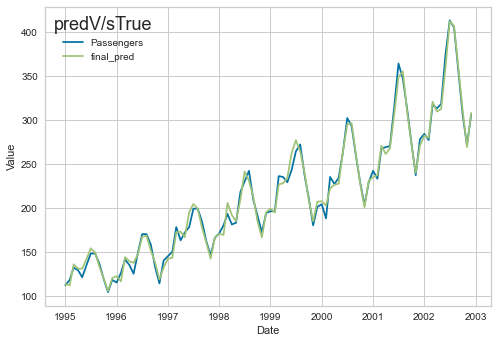

In [68]:
# line plot View for the entire dataset (final Model)
viz8 = data_final.loc[:,["Date","Passengers","final_pred"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz8, x=viz8.Date, y=viz8.Value,hue="predV/sTrue")
#Best model

In [69]:
#predicting
predn = pd.DataFrame(final_model.forecast(24)).reset_index()
predn.rename(columns={'index':'t',0:'Forecast'},inplace=True)
predn

,t,Forecast
0,96,312.899768
1,97,308.171843
2,98,355.533483
3,99,345.770653
4,100,345.697050
5,101,392.471899
6,102,436.502735
7,103,429.860677
8,104,380.174322
9,105,332.318746


In [70]:
#forecast dataset
forecast= pd.concat([data_final,predn], axis=0)
forecast.drop('Date',axis=1)
forecast['Date']=pd.date_range(start='1995-01-01', end = '2004-12-01', freq = 'MS')

In [71]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 23
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   t           120 non-null    int64         
 1   year        96 non-null     object        
 2   month       96 non-null     object        
 3   Passengers  96 non-null     float64       
 4   final_pred  96 non-null     float64       
 5   Date        120 non-null    datetime64[ns]
 6   Forecast    24 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 7.5+ KB


<AxesSubplot:xlabel='Date', ylabel='Value'>

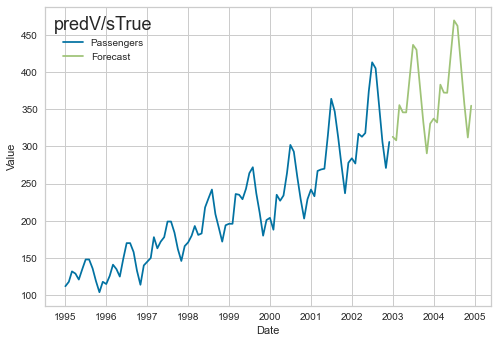

In [72]:
#forecast plot
viz9 = forecast.loc[:,["Date","Passengers","Forecast"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz9, x=viz9.Date, y=viz9.Value,hue="predV/sTrue")

Q2

Forecast the CocaCola prices. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [74]:
new_data=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
new_data
data = new_data.copy()

In [75]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [76]:
v=pd.read_excel('CocaCola_Sales_Rawdata.xlsx',
                  header=0,index_col=0,parse_dates=True,squeeze=True)
v[:6]

Quarter
Q1_86    1734.827000
Q2_86    2244.960999
Q3_86    2533.804993
Q4_86    2154.962997
Q1_87    1547.818996
Q2_87    2104.411995
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Quarter', ylabel='Sales'>

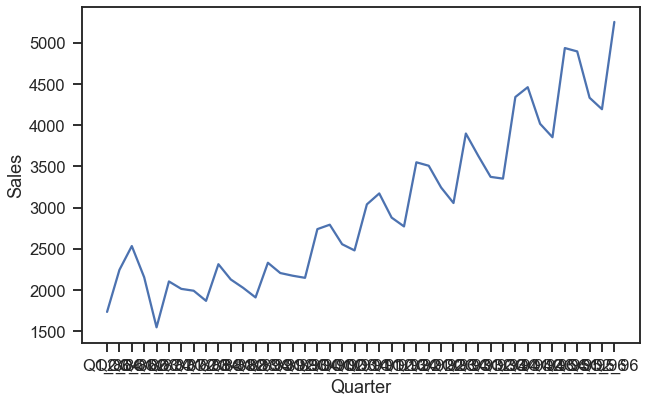

In [78]:
#Line plot
sns.set(rc={'figure.figsize':(10,6.18)})
sns.set(style="ticks", context="talk")
sns.lineplot(data=v)

<AxesSubplot:xlabel='Sales', ylabel='Count'>

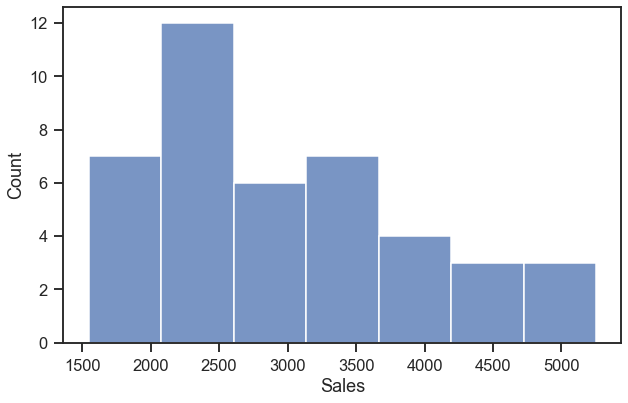

In [79]:
sns.histplot(data=v)

<AxesSubplot:xlabel='Sales', ylabel='Density'>

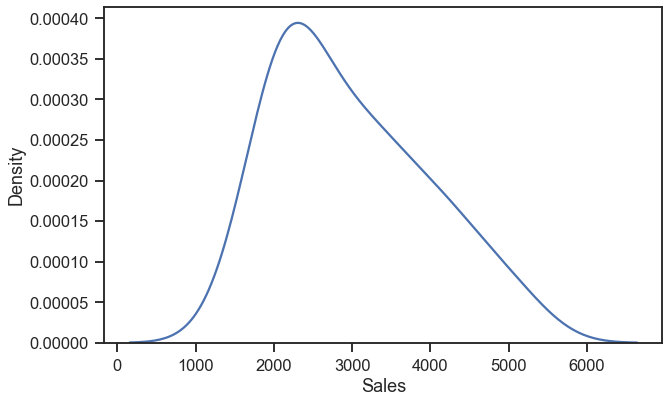

In [80]:
#Density Plot
sns.kdeplot(data=v)

In [81]:
data['quarters'] = data.Quarter.apply(lambda x : x.split('_')[0])
data['years'] = data.Quarter.apply(lambda x : x.split('_')[1])
data

,Quarter,Sales,quarters,years
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87
5,Q2_87,2104.411995,Q2,87
6,Q3_87,2014.362999,Q3,87
7,Q4_87,1991.746998,Q4,87
8,Q1_88,1869.049999,Q1,88
9,Q2_88,2313.631996,Q2,88


In [82]:
quater_dumies=pd.DataFrame(pd.get_dummies(data.quarters))
data=pd.concat([data,quater_dumies],axis=1)
data

,Quarter,Sales,quarters,years,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0
5,Q2_87,2104.411995,Q2,87,0,1,0,0
6,Q3_87,2014.362999,Q3,87,0,0,1,0
7,Q4_87,1991.746998,Q4,87,0,0,0,1
8,Q1_88,1869.049999,Q1,88,1,0,0,0
9,Q2_88,2313.631996,Q2,88,0,1,0,0


Text(0.5, 1.0, 'Heatmap of Sales Count with Year and Quarters')

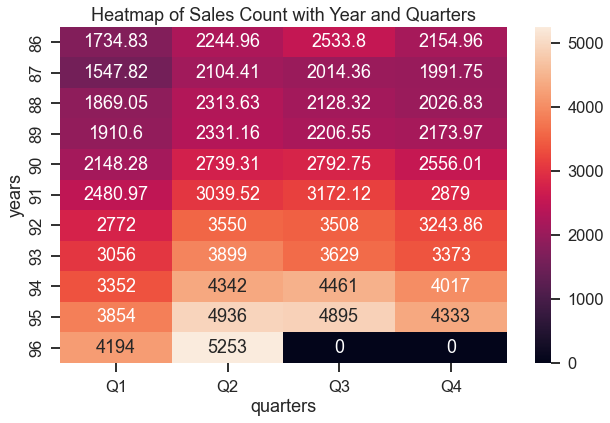

In [83]:
heatmap_y_month = pd.pivot_table(data=data,values="Sales",index="years",columns="quarters",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.title('Heatmap of Sales Count with Year and Quarters')

<AxesSubplot:xlabel='quarters', ylabel='Sales'>

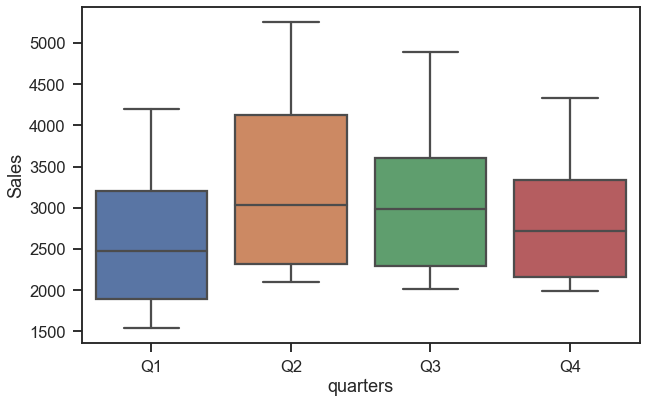

In [84]:
sns.boxplot(x='quarters',y='Sales',data=data)

<AxesSubplot:xlabel='years', ylabel='Sales'>

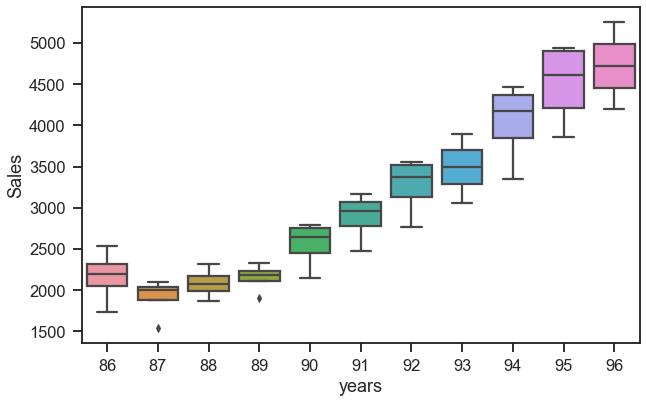

In [85]:
sns.boxplot(x='years',y='Sales',data=data)

In [113]:
#sesonal decompose plot
decompose_ts = seasonal_decompose(v,period=12)

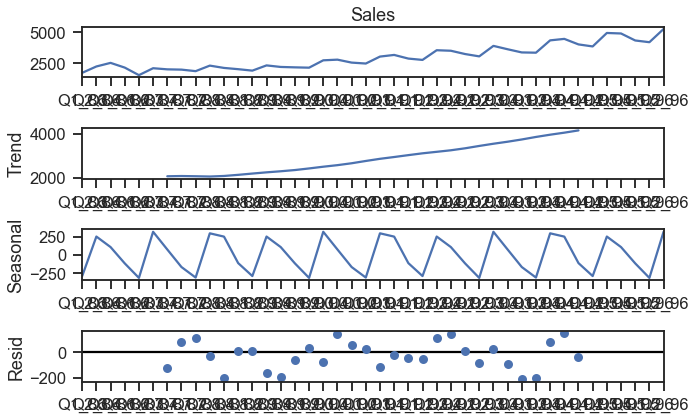

In [114]:
decompose_ts.plot()
plt.show()

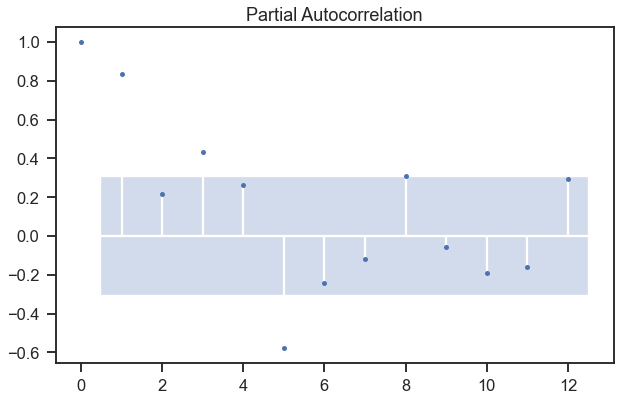

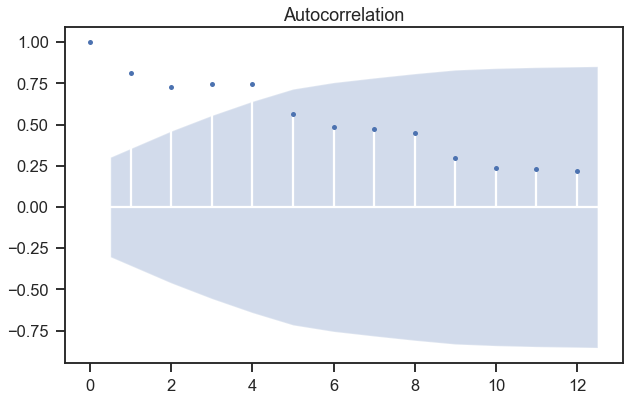

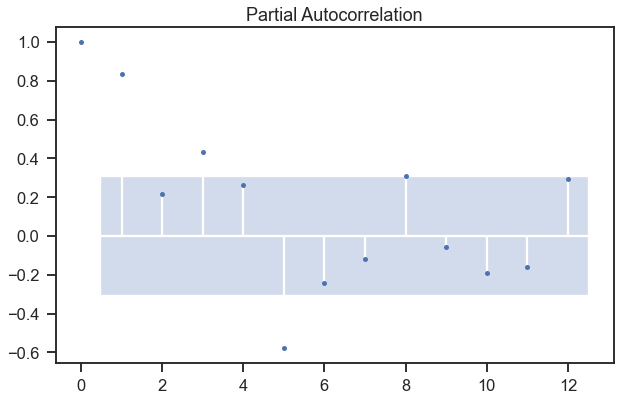

In [115]:
#ACF
tsa_plots.plot_acf(v,lags=12) 
#PACF
tsa_plots.plot_pacf(v,lags=12) 

In [89]:
#transformations
# adding t values >> new variable 1
data['t']= np.arange(1,data.shape[0]+1) 

In [90]:
# adding t_sqr values >> new variable 2
data['t_sqr'] = data['t']**2

In [92]:
# adding log_ values >> new variable 3
data['log_sales'] = np.log(data['Sales'])
data

,Quarter,Sales,quarters,years,Q1,Q2,Q3,Q4,t,t_sqr,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602
5,Q2_87,2104.411995,Q2,87,0,1,0,0,6,36,7.651791
6,Q3_87,2014.362999,Q3,87,0,0,1,0,7,49,7.608058
7,Q4_87,1991.746998,Q4,87,0,0,0,1,8,64,7.596767
8,Q1_88,1869.049999,Q1,88,1,0,0,0,9,81,7.533186
9,Q2_88,2313.631996,Q2,88,0,1,0,0,10,100,7.746574


In [93]:
#Partition Series
train = data.iloc[:35]
test = data.iloc[35:]

In [96]:
#performance metrics (model driven and data driven) 
pfm_model_bsd = dict()
pfm_data_bsd = dict()

In [98]:
#model driven forecasting methods
#Linear Model
linear_model = smf.ols('Sales~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = mean_squared_error(test.Sales, pred_linear, squared=False) #RMSE Calculation
pfm_model_bsd.update( {'Linear Model' : rmse_linear} )
rmse_linear

636.5072930351143

In [99]:
#Exponential
Exp = smf.ols('log_sales~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = mean_squared_error(test.Sales, pred_Exp, squared=False)
pfm_model_bsd.update( {'Exponential Model' : rmse_Exp} )
rmse_Exp

4515.811064811282

In [100]:
#Quadratic 
Quad = smf.ols('Sales~t+t_sqr',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_sqr"]]))
rmse_Quad = mean_squared_error(test.Sales,pred_Quad, squared=False)
pfm_model_bsd.update( {'Quadratic Model' : rmse_Quad} )
rmse_Quad

511.811731941731

In [101]:
#Additive seasonality 
add_sea = smf.ols('Sales~Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea = mean_squared_error(test.Sales,pred_add_sea, squared=False)
pfm_model_bsd.update( {'Additive seasonality' : rmse_add_sea} )
rmse_add_sea

1861.8704164251742

In [102]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Sales~t+t_sqr+Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Q1','Q2','Q3','Q4','t','t_sqr']]))
rmse_add_sea_quad = mean_squared_error(test.Sales,pred_add_sea_quad, squared=False)
pfm_model_bsd.update( {'Additive Seasonality Quadratic' : rmse_add_sea_quad} )
rmse_add_sea_quad

309.46413951642813

In [103]:
#Multiplicative Seasonality
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3+Q4',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = mean_squared_error(test.Sales,pred_Mult_sea, squared=False)
pfm_model_bsd.update( {'Multiplicative Seasonality' : rmse_Mult_sea} )
rmse_Mult_sea

4516.300741074347

In [104]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3+Q4',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = mean_squared_error(test.Sales,pred_Mult_add_sea, squared=False)
pfm_model_bsd.update( {'Multiplicative Additive Seasonality ' : rmse_Mult_add_sea} )
rmse_Mult_add_sea 

4515.822756171213

In [105]:
result_model_bsd = pd.DataFrame(pfm_model_bsd.items(),columns=['MODEL', 'RMSE'])
result_model_bsd.sort_values(by=['RMSE'])
#Additive Seasonality Quadratic have lowest RMSE

,MODEL,RMSE
4,Additive Seasonality Quadratic,309.464140
2,Quadratic Model,511.811732
0,Linear Model,636.507293
3,Additive seasonality,1861.870416
1,Exponential Model,4515.811065
6,Multiplicative Additive Seasonality,4515.822756
5,Multiplicative Seasonality,4516.300741


In [106]:
#evaluating ASQ
data2 = data.copy()
data2

,Quarter,Sales,quarters,years,Q1,Q2,Q3,Q4,t,t_sqr,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602
5,Q2_87,2104.411995,Q2,87,0,1,0,0,6,36,7.651791
6,Q3_87,2014.362999,Q3,87,0,0,1,0,7,49,7.608058
7,Q4_87,1991.746998,Q4,87,0,0,0,1,8,64,7.596767
8,Q1_88,1869.049999,Q1,88,1,0,0,0,9,81,7.533186
9,Q2_88,2313.631996,Q2,88,0,1,0,0,10,100,7.746574


In [107]:
data2.columns.values

array(['Quarter', 'Sales', 'quarters', 'years', 'Q1', 'Q2', 'Q3', 'Q4',
       't', 't_sqr', 'log_sales'], dtype=object)

In [108]:
data2.drop(['Quarter','Q1', 'Q2', 'Q3', 'Q4','t_sqr', 'log_sales'], axis=1, inplace=True)
data2 = data2[['t', 'years', 'quarters', 'Sales']] 
data1 = data2.copy()
data3 = data2.copy()
data_final = data2.copy()
data2

,t,years,quarters,Sales
0,1,86,Q1,1734.827000
1,2,86,Q2,2244.960999
2,3,86,Q3,2533.804993
3,4,86,Q4,2154.962997
4,5,87,Q1,1547.818996
5,6,87,Q2,2104.411995
6,7,87,Q3,2014.362999
7,8,87,Q4,1991.746998
8,9,88,Q1,1869.049999
9,10,88,Q2,2313.631996


In [109]:
data2["Predicted"] = pd.Series(add_sea_Quad.predict(data[['Q1','Q2','Q3','Q4','t','t_sqr']]))
data2

,t,years,quarters,Sales,Predicted
0,1,86,Q1,1734.827000,1715.011163
1,2,86,Q2,2244.960999,2277.750192
2,3,86,Q3,2533.804993,2194.873446
3,4,86,Q4,2154.962997,1919.651866
4,5,87,Q1,1547.818996,1703.261332
5,6,87,Q2,2104.411995,2283.439187
6,7,87,Q3,2014.362999,2218.001266
7,8,87,Q4,1991.746998,1960.218512
8,9,88,Q1,1869.049999,1761.266805
9,10,88,Q2,2313.631996,2358.883485


In [110]:
# adding date column in the dataset
data2['Date'] = pd.date_range(start='1986-01-01', end = '1996-07-01', freq = 'Q')
data2

,t,years,quarters,Sales,Predicted,Date
0,1,86,Q1,1734.827000,1715.011163,1986-03-31
1,2,86,Q2,2244.960999,2277.750192,1986-06-30
2,3,86,Q3,2533.804993,2194.873446,1986-09-30
3,4,86,Q4,2154.962997,1919.651866,1986-12-31
4,5,87,Q1,1547.818996,1703.261332,1987-03-31
5,6,87,Q2,2104.411995,2283.439187,1987-06-30
6,7,87,Q3,2014.362999,2218.001266,1987-09-30
7,8,87,Q4,1991.746998,1960.218512,1987-12-31
8,9,88,Q1,1869.049999,1761.266805,1988-03-31
9,10,88,Q2,2313.631996,2358.883485,1988-06-30


<AxesSubplot:xlabel='Date', ylabel='Value'>

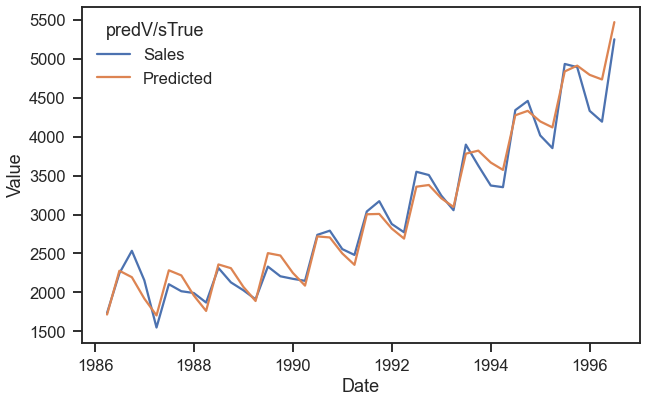

In [116]:
# line plot for the entire dataset (ASQ)
v2 = data2.loc[:,["Date","Sales","Predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz2, x=viz2.Date, y=v2.Value,hue="predV/sTrue")

<AxesSubplot:xlabel='Date', ylabel='Value'>

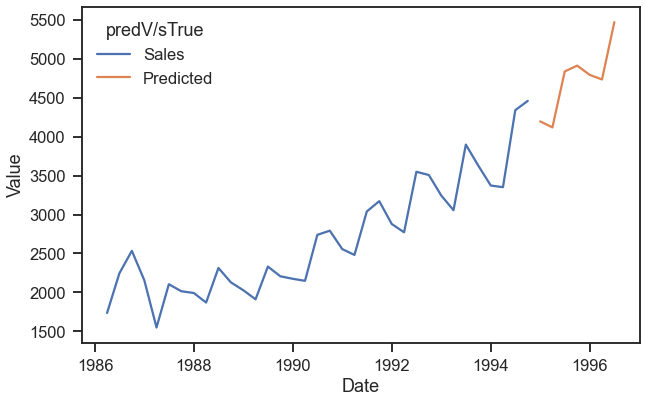

In [118]:
#Line plot Train V Test Plot
data2.Predicted.iloc[:35] = np.nan
data2.Sales.iloc[35:] = np.nan

v3 = data2.loc[:,["Date","Sales","Predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=v3, x=v3.Date, y=v3.Value,hue="predV/sTrue")
#There is large variance from true value

In [119]:
#Partition Series
train1 = data1.iloc[:35]
test1 = data1.iloc[35:]

In [120]:
# pycaret regression module
# initialize setup
s = setup(data = train1, test_data = test1, target = 'Sales', 
          fold_strategy = 'timeseries', numeric_features = ['years', 't'], 
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Sales
2,Original Data,"(35, 4)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(35, 6)"


In [121]:
best = compare_models(sort = 'RMSE')

prediction_holdout = predict_model(best)
# lowest RMSE for huber regressor

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,307.0714,158955.2634,350.2645,-0.2920,0.1309,0.1061,0.0067
gbr,Gradient Boosting Regressor,299.7615,167676.6230,403.7827,-0.1156,0.1305,0.0928,0.0100
dt,Decision Tree Regressor,324.9201,177179.8881,412.0147,-0.1376,0.1332,0.1008,0.0067
br,Bayesian Ridge,358.4199,184113.4097,413.8704,-0.4449,0.1485,0.1197,0.0067
ridge,Ridge Regression,361.2944,185395.6094,415.3162,-0.4618,0.1502,0.1213,0.5300
lr,Linear Regression,374.1765,192677.2474,422.7920,-0.5560,0.1590,0.1285,1.0267
lar,Least Angle Regression,375.8673,193915.8587,425.1591,-0.5597,0.1596,0.1289,0.0067
et,Extra Trees Regressor,351.7371,196713.7477,434.6764,-0.2868,0.1445,0.1098,0.0333
ada,AdaBoost Regressor,359.7444,205411.4173,443.1730,-0.3448,0.1472,0.1129,0.0167
rf,Random Forest Regressor,345.7391,210915.5866,449.3528,-0.3744,0.1471,0.1072,0.0367


In [123]:
# predictions on the original dataset
predictions = predict_model(best, data=data1)
predictions

,t,years,quarters,Sales,Label
0,1,86,Q1,1734.827000,1575.795937
1,2,86,Q2,2244.960999,1916.533205
2,3,86,Q3,2533.804993,1892.576027
3,4,86,Q4,2154.962997,1779.082826
4,5,87,Q1,1547.818996,1709.488701
5,6,87,Q2,2104.411995,2094.112201
6,7,87,Q3,2014.362999,2066.942780
7,8,87,Q4,1991.746998,1938.487341
8,9,88,Q1,1869.049999,1859.930882
9,10,88,Q2,2313.631996,2296.071081


In [126]:
# adding date column in the dataset
predictions['Date'] = pd.date_range(start='1986-01-01', end = '1996-07-01', freq = 'Q')
data_A = predictions.copy()
data4 =  predictions.copy()
predictions

,t,years,quarters,Sales,Label,Date
0,1,86,Q1,1734.827000,1575.795937,1986-03-31
1,2,86,Q2,2244.960999,1916.533205,1986-06-30
2,3,86,Q3,2533.804993,1892.576027,1986-09-30
3,4,86,Q4,2154.962997,1779.082826,1986-12-31
4,5,87,Q1,1547.818996,1709.488701,1987-03-31
5,6,87,Q2,2104.411995,2094.112201,1987-06-30
6,7,87,Q3,2014.362999,2066.942780,1987-09-30
7,8,87,Q4,1991.746998,1938.487341,1987-12-31
8,9,88,Q1,1869.049999,1859.930882,1988-03-31
9,10,88,Q2,2313.631996,2296.071081,1988-06-30


<AxesSubplot:xlabel='Date', ylabel='Value'>

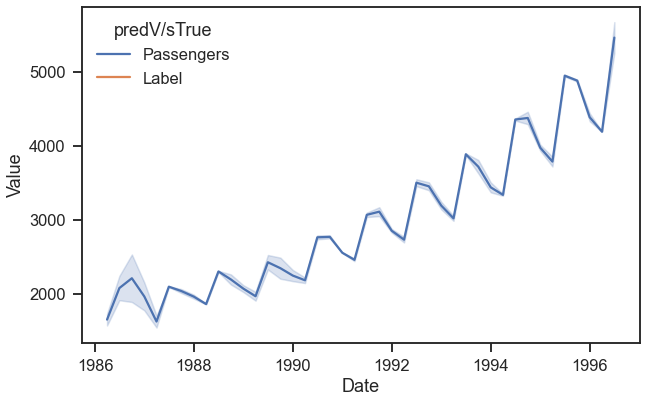

In [127]:
# line plot for the entire dataset

vis1 = predictions.loc[:,["Date","Sales","Label"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=viz1, x=vis1.Date, y=vis1.Value,hue="predV/sTrue")

<AxesSubplot:xlabel='Date', ylabel='Value'>

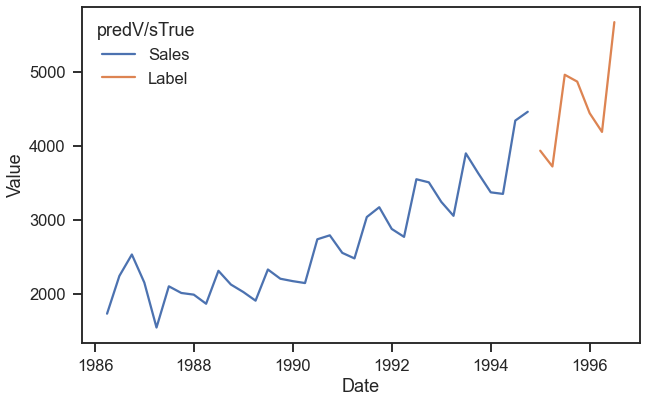

In [128]:
# line plot for Train V test

predictions.Label.iloc[:35] = np.nan
predictions.Sales.iloc[35:] = np.nan

vis2 = predictions.loc[:,["Date","Sales","Label"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=vis2, x=vis2.Date, y=vis2.Value,hue="predV/sTrue")

In [129]:
#Data driven forecasting
#Making seperate dataset

data_A = data_A.set_index('Date')

#Simple Moving Average SMA
data_A['3-month-SMA'] = data_A['Sales'].rolling(window=3).mean()
data_A['6-month-SMA'] = data_A['Sales'].rolling(window=6).mean()
data_A['12-month-SMA'] = data_A['Sales'].rolling(window=12).mean()

<AxesSubplot:xlabel='Date'>

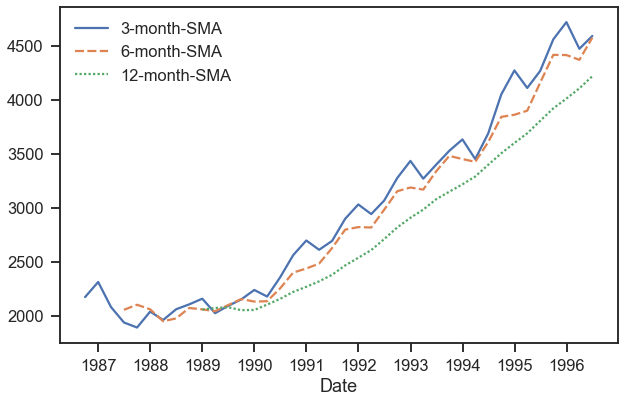

In [130]:
#SMA plot
sns.lineplot(data=data_A[['3-month-SMA','6-month-SMA','12-month-SMA']],)

In [131]:
#3-Months only with lowest SMA
data_A['3-month-SMA']=data_A['3-month-SMA'].fillna(0)
rmse_SMA_3Months = mean_squared_error(data_A.Sales,data_A['3-month-SMA'], squared=False)
pfm_data_bsd.update({'SMA-3Months':rmse_SMA_3Months}) 
rmse_SMA_3Months

530.974317734843

<AxesSubplot:xlabel='Date'>

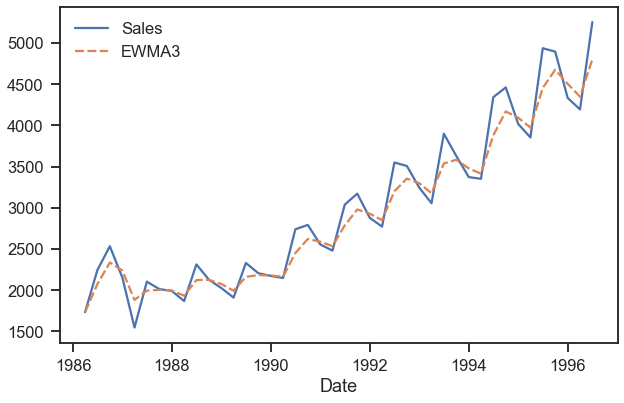

In [132]:
#Exponentially Weighted Moving Average EWMA
data_A['EWMA3'] = data_A['Sales'].ewm(span=3,adjust=True).mean() #3month Span

#Line Plot EWMA
#SMA plot
sns.lineplot(data=data_A[["Sales","EWMA3"]])

In [ ]:
#for 3-Months only since it will have the lowest EWMA
data_ma['EWMA3'] =data_ma['EWMA3'] .fillna(0)
rmse_EWMA3 = mean_squared_error(data_ma.Sales,data_ma['EWMA3'] , squared=False)
pfm_data_bsd.update({'EWMA 3Months':rmse_EWMA3}) 
rmse_EWMA3 #This is a low value but it alone cannot be taken

In [133]:
#3-Months only since it will have the lowest EWMA
data_A['EWMA3'] =data_A['EWMA3'] .fillna(0)
rmse_EWMA3 = mean_squared_error(data_A.Sales,data_A['EWMA3'] , squared=False)
pfm_data_bsd.update({'EWMA 3Months':rmse_EWMA3}) 
rmse_EWMA3

199.4860437981679

In [134]:
#smoothing
#Simple Exponential Method
ses_model = SimpleExpSmoothing(train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
rmse_SES = mean_squared_error(test.Sales,pred_ses, squared=False)
pfm_data_bsd.update({'SES':rmse_SES}) 
rmse_SES

922.9178308307818

In [135]:
# Holt method 
hw_model = Holt(train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
rmse_Holt = mean_squared_error(test.Sales,pred_hw, squared=False)
pfm_data_bsd.update({'Holt':rmse_Holt}) 
rmse_Holt

796.7270706021932

In [136]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_add = mean_squared_error(test.Sales,pred_hwe_add_add, squared=False)
pfm_data_bsd.update({'HWE Add. Seas & Add. Trend':rmse_hwe_add}) 
rmse_hwe_add

270.0779086581699

In [137]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_mul = mean_squared_error(test.Sales,pred_hwe_mul_add, squared=False)
pfm_data_bsd.update({'HWE Mul. Seas & Add. Trend':rmse_hwe_mul}) 
rmse_hwe_mul #lowest                                          

129.2574612883441

In [ ]:
#Lowest RSME values are for HWE Multiplicative Seasonality and Additive Trend

In [138]:
#model - HWEMS and AT
hwe_mul_model = hwe_model_mul_add.predict(start = data.index[0],end = data.index[-1])
data3['predicted'] = hwe_mul_model
data3

,t,years,quarters,Sales,predicted
0,1,86,Q1,1734.827000,1791.544872
1,2,86,Q2,2244.960999,2122.596467
2,3,86,Q3,2533.804993,2344.352626
3,4,86,Q4,2154.962997,2196.416747
4,5,87,Q1,1547.818996,1822.266507
5,6,87,Q2,2104.411995,2122.991841
6,7,87,Q3,2014.362999,1946.055712
7,8,87,Q4,1991.746998,1852.265032
8,9,88,Q1,1869.049999,1849.273983
9,10,88,Q2,2313.631996,2302.048508


In [139]:
# adding a date column in the dataset
data3['Date'] = pd.date_range(start='1986-01-01', end = '1996-07-01', freq = 'Q')
data3

,t,years,quarters,Sales,predicted,Date
0,1,86,Q1,1734.827000,1791.544872,1986-03-31
1,2,86,Q2,2244.960999,2122.596467,1986-06-30
2,3,86,Q3,2533.804993,2344.352626,1986-09-30
3,4,86,Q4,2154.962997,2196.416747,1986-12-31
4,5,87,Q1,1547.818996,1822.266507,1987-03-31
5,6,87,Q2,2104.411995,2122.991841,1987-06-30
6,7,87,Q3,2014.362999,1946.055712,1987-09-30
7,8,87,Q4,1991.746998,1852.265032,1987-12-31
8,9,88,Q1,1869.049999,1849.273983,1988-03-31
9,10,88,Q2,2313.631996,2302.048508,1988-06-30


<AxesSubplot:xlabel='Date', ylabel='Value'>

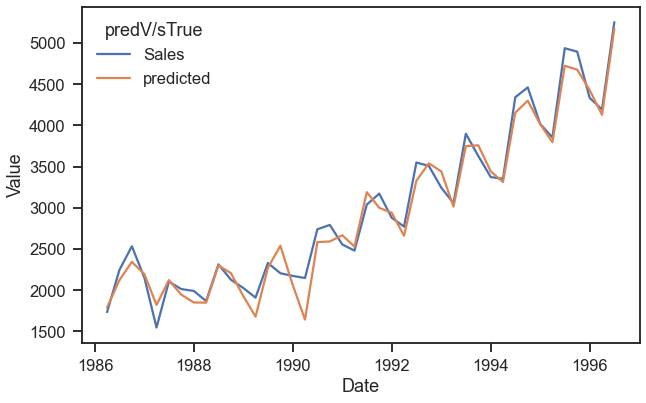

In [143]:
# line plot for the entire dataset ASQ
vis3 = data3.loc[:,["Date","Sales","predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=vis3, x=vis3.Date, y=vis3.Value,hue="predV/sTrue")
#lowest RMSE for this model

<AxesSubplot:xlabel='Date', ylabel='Value'>

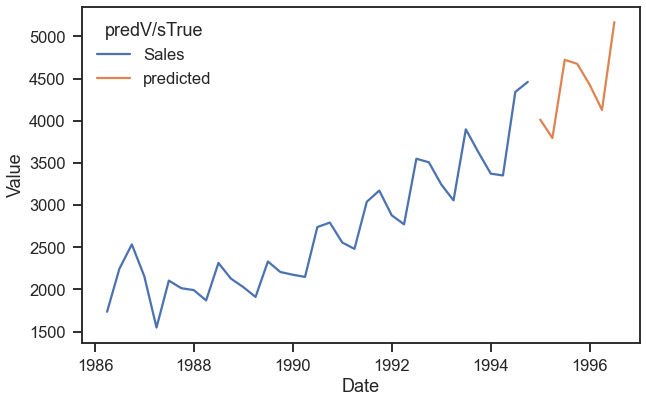

In [144]:
#Line plot Train V Test Plot
data3.predicted.iloc[:35] = np.nan
data3.Sales.iloc[35:] = np.nan

vis4 = data3.loc[:,["Date","Sales","predicted"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=vis4, x=vis4.Date, y=vis4.Value,hue="predV/sTrue")

In [ ]:
#performing AD-Fuller test to check stationarity of the data

In [145]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [146]:
data4=data4.set_index('Date')
data4

,t,years,quarters,Sales,Label
Date,,,,,
1986-03-31,1,86,Q1,1734.827000,1575.795937
1986-06-30,2,86,Q2,2244.960999,1916.533205
1986-09-30,3,86,Q3,2533.804993,1892.576027
1986-12-31,4,86,Q4,2154.962997,1779.082826
1987-03-31,5,87,Q1,1547.818996,1709.488701
1987-06-30,6,87,Q2,2104.411995,2094.112201
1987-09-30,7,87,Q3,2014.362999,2066.942780
1987-12-31,8,87,Q4,1991.746998,1938.487341
1988-03-31,9,88,Q1,1869.049999,1859.930882


In [147]:
#AD- Fuller test
adf_test(data4[['Sales']])
#non stationary data

Fail to reject the null hypothesis
Data is non-stationary


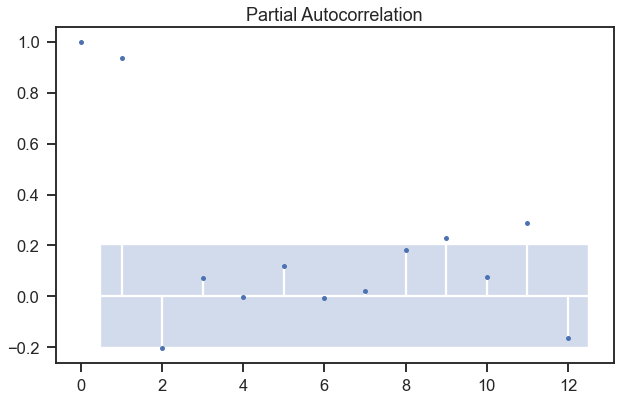

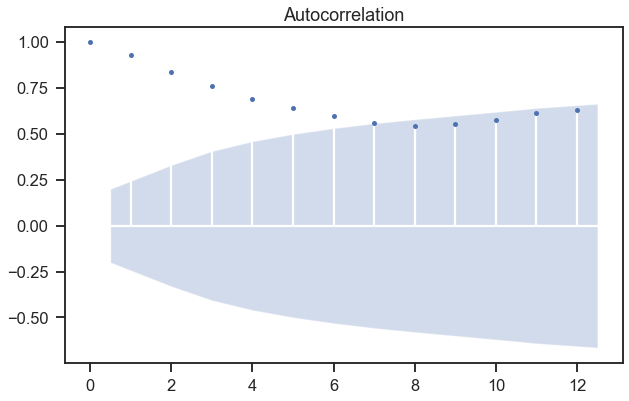

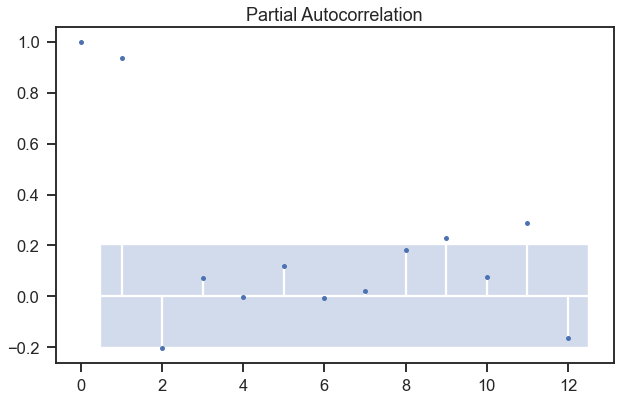

In [148]:
#ACF and PACF Plots
tsa_plots.plot_acf(viz,lags=12) 

tsa_plots.plot_pacf(viz,lags=12) 

In [ ]:
#run a auto arima to determine ARIMA orders

In [149]:
stepwise_fit = auto_arima(data4.Sales, start_p=0, start_q=0,
                          max_p=12, max_q=12, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,  
                          stepwise=True)          

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=617.615, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=619.036, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=607.723, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=617.215, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=608.949, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=606.079, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=607.920, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=596.966, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=579.745, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=592.020, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=559.112, Time=0.12 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -271.119
Date:                Wed, 05 Jan 2022   AIC                            554.239
Time:                        18:50:29   BIC                            564.520
Sample:                             0   HQIC                           557.983
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     74.4164     34.615      2.150      0.032       6.572     142.261
ar.L1         -0.2568      0.132     -1.949      0.051      -0.515       0.001
ar.L2         -0.3022      0.125     -2.417      0.016      -0.547      -0.057
ar.L3         -0.2225      0.155     -1.439      0.150      -0.526       0.081
ar.L4          0.6647      0.124      5.359      0.000       0.422       0.908
sigma2      2.756e+04   6171.005      4.466      0.000    1.55e+04    3.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 4.03
Prob(Q):                              0.64   Prob(JB):                         0.13
Heteroskedasticity (H):               0.56   Skew:                            -0.39
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
#model fitting

model_arima = ARIMA(train['Sales'],order=(4,1,0))
results = model_arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                   34
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -226.383
Method:                       css-mle   S.D. of innovations            173.547
Date:                Wed, 05 Jan 2022   AIC                            464.765
Time:                        18:50:47   BIC                            473.923
Sample:                             1   HQIC                           467.888
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            61.5056     33.777      1.821      0.069      -4.696     127.707
ar.L1.D.Sales    -0.1806      0.135     -1.339      0.181      -0.445       0.084
ar.L2.D.Sales    -0.2311      0.141     -1.639      0.101      -0.507       0.045
ar.L3.D.Sales    -0.1456      0.150     -0.971      0.332      -0.440       0.148
ar.L4.D.Sales     0.7209      0.145      4.986      0.000       0.438       1.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0558           -0.0000j            1.0558           -0.5000
AR.2           -0.0089           -1.0149j            1.0149           -0.2514
AR.3           -0.0089           +1.0149j            1.0149            0.2514
AR.4            1.2756           -0.0000j            1.2756           -0.0000
-----------------------------------------------------------------------------
"""

In [151]:
pred_arima = results.predict(start=35, end=len(data4)-1, dynamic=False, typ='levels')

In [152]:
#RMSE score of ARIMA
rmse_arima= mean_squared_error(test.Sales,pred_arima, squared=False)
rmse_arima
#low RMSE value but not to be used because we have better model

134.3354890845266

In [154]:
#using huber regressor for the final model
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
final_model = ExponentialSmoothing(data_final["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_final = final_model.predict(start = data.index[0],end = data.index[-1])

#Getting RMSE Score
rmse_final = mean_squared_error(data.Sales,pred_final, squared=False)
rmse_final

154.65045948427777

In [155]:
data_final

,t,years,quarters,Sales
0,1,86,Q1,1734.827000
1,2,86,Q2,2244.960999
2,3,86,Q3,2533.804993
3,4,86,Q4,2154.962997
4,5,87,Q1,1547.818996
5,6,87,Q2,2104.411995
6,7,87,Q3,2014.362999
7,8,87,Q4,1991.746998
8,9,88,Q1,1869.049999
9,10,88,Q2,2313.631996


In [157]:
data_final['final_pred']=pred_final
data_final

,t,years,quarters,Sales,final_pred
0,1,86,Q1,1734.827000,1751.064582
1,2,86,Q2,2244.960999,2141.909936
2,3,86,Q3,2533.804993,2333.029922
3,4,86,Q4,2154.962997,2243.157448
4,5,87,Q1,1547.818996,1906.522788
5,6,87,Q2,2104.411995,2202.186659
6,7,87,Q3,2014.362999,1991.983988
7,8,87,Q4,1991.746998,1886.066586
8,9,88,Q1,1869.049999,1893.907949
9,10,88,Q2,2313.631996,2338.360352


In [158]:
data_final['Date'] = pd.date_range(start='1986-01-01', end = '1996-07-01', freq = 'Q')
data_final

,t,years,quarters,Sales,final_pred,Date
0,1,86,Q1,1734.827000,1751.064582,1986-03-31
1,2,86,Q2,2244.960999,2141.909936,1986-06-30
2,3,86,Q3,2533.804993,2333.029922,1986-09-30
3,4,86,Q4,2154.962997,2243.157448,1986-12-31
4,5,87,Q1,1547.818996,1906.522788,1987-03-31
5,6,87,Q2,2104.411995,2202.186659,1987-06-30
6,7,87,Q3,2014.362999,1991.983988,1987-09-30
7,8,87,Q4,1991.746998,1886.066586,1987-12-31
8,9,88,Q1,1869.049999,1893.907949,1988-03-31
9,10,88,Q2,2313.631996,2338.360352,1988-06-30


<AxesSubplot:xlabel='Date', ylabel='Value'>

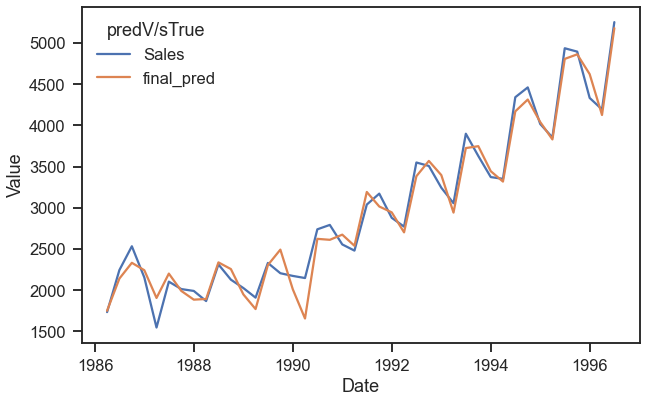

In [160]:
# line plot for final Model
visfinal = data_final.loc[:,["Date","Sales","final_pred"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=visfinal, x=visfinal.Date, y=visfinal.Value,hue="predV/sTrue")

In [161]:
pred1 = pd.DataFrame(final_model.forecast(8)).reset_index()
pred1.rename(columns={'index':'t',0:'Forecast'},inplace=True)
pred1

,t,Forecast
0,42,4929.498608
1,43,4614.623753
2,44,4554.130175
3,45,5773.661620
4,46,5819.106671
5,47,5235.769937
6,48,4978.866235
7,49,6256.435076


In [162]:
#forecast dataset
forecast= pd.concat([data_final,pred1], axis=0)
forecast.drop('Date',axis=1)
forecast['Date']=pd.date_range(start='1986-01-01', end = '1998-09-01', freq = 'Q')
forecast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 7
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   t           50 non-null     int64         
 1   years       42 non-null     object        
 2   quarters    42 non-null     object        
 3   Sales       42 non-null     float64       
 4   final_pred  42 non-null     float64       
 5   Date        50 non-null     datetime64[ns]
 6   Forecast    8 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 3.1+ KB


<AxesSubplot:xlabel='Date', ylabel='Value'>

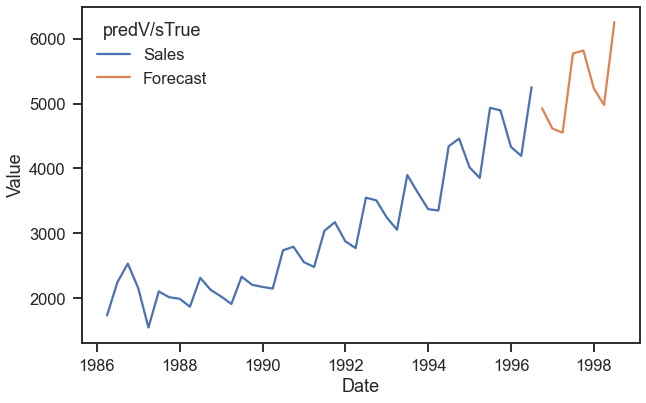

In [163]:
#forecaste future
vis5 = forecast.loc[:,["Date","Sales","Forecast"]].melt("Date",var_name="predV/sTrue",value_name="Value")
sns.lineplot(data=vis5, x=vis5.Date, y=vis5.Value,hue="predV/sTrue")